## Loading Dataset

In [1]:
import pandas as pd
import numpy as np

In [13]:
import json

with open("review-Iowa_10.json", 'r') as f:
    lines = f.readlines()

# Filter out empty lines and attempt to parse each line as JSON
parsed_data = []
for line in lines:
    stripped_line = line.strip()
    if stripped_line:
        try:
            parsed_data.append(json.loads(stripped_line))
        except json.JSONDecodeError:
            # Skip lines that cause JSONDecodeError
            pass

# Create DataFrame from the list of parsed JSON objects
df = pd.DataFrame(parsed_data)
df.head()

,user_id,name,time,rating,text,pics,resp,gmap_id
0,115499682928803397674,Nicole Williams,1528935574441,5,I have found my new favorite nail shop. I love...,None,"{'time': 1528950923185, 'text': 'Thanks'}",0x87ec238afdd8837b:0x2f43f2b12142bff5
1,110072671534171333918,Dmitriy N,1575832576112,5,This place is awesome. Got my pedicure there a...,None,"{'time': 1576094549338, 'text': 'Thanks , Dmit...",0x87ec238afdd8837b:0x2f43f2b12142bff5
2,117021476131280107146,Sue Dickman,1465139905809,5,I love going to Polished Nails. Everyone is pr...,None,None,0x87ec238afdd8837b:0x2f43f2b12142bff5
3,109003155465609632997,Ashley Nguyen,1565271263810,5,Nice place to get a complete set.,None,"{'time': 1565752414209, 'text': 'Thanks'}",0x87ec238afdd8837b:0x2f43f2b12142bff5
4,113278552835557781367,Candy Hester,1450564402784,5,Great manicure from someone who really cares f...,None,None,0x87ec238afdd8837b:0x2f43f2b12142bff5


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155774 entries, 0 to 155773
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  155774 non-null  object
 1   name     155774 non-null  object
 2   time     155774 non-null  int64 
 3   rating   155774 non-null  int64 
 4   text     83464 non-null   object
 5   pics     2930 non-null    object
 6   resp     18682 non-null   object
 7   gmap_id  155774 non-null  object
dtypes: int64(2), object(6)
memory usage: 9.5+ MB


In [15]:
df['rating'].unique()

array([5, 1, 3, 2, 4])

In [16]:
drop_columns = ["user_id", "name", "time", "pics", "resp", "gmap_id"]
df = df.drop(columns=drop_columns)
df.head()

,rating,text
0,5,I have found my new favorite nail shop. I love...
1,5,This place is awesome. Got my pedicure there a...
2,5,I love going to Polished Nails. Everyone is pr...
3,5,Nice place to get a complete set.
4,5,Great manicure from someone who really cares f...


In [17]:
df.dropna(inplace=True)

In [18]:
df1 = df[df['rating'] == 1]
df2 = df[df['rating'] == 2]
df3 = df[df['rating'] == 3]
df4 = df[df['rating'] == 4]
df5 = df[df['rating'] == 5]

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)

(5576, 2)
(2706, 2)
(5356, 2)
(13127, 2)
(56699, 2)


In [19]:
"""
Since this dataset is extremely skewed for positive ratings, and this is
realistic with real-world data but for learning and fine-tuning BERT, I think
it's good to rebalance by randomly sampling some percentage of the data.

For ratings 1 and 2, I will keep 2k reviews and making this class 'negative'.
For rating 3, I will keep 4k reviews and make this class 'neutral'.
For ratings 4 and 5, I will keep 2k reviews and make this class 'positive'.
"""
df1 = df1.iloc[np.random.choice(len(df1), size=2000, replace=False)]
df2 = df2.iloc[np.random.choice(len(df2), size=2000, replace=False)]
df3 = df3.iloc[np.random.choice(len(df3), size=4000, replace=False)]
df4 = df4.iloc[np.random.choice(len(df4), size=2000, replace=False)]
df5 = df5.iloc[np.random.choice(len(df5), size=2000, replace=False)]
df = pd.concat([df1, df2, df3, df4, df5])
df

,rating,text
90614,1,Never clean and there r some good employees b...
53078,1,I was in the store looking for shoes for my 20...
142831,1,Staff is super friendly but the store is very ...
5217,1,Nasty and horrible service
59740,1,We had a flat tire that was barely pumped enou...
...,...,...
101163,5,This is by far the best crossfit gym in Cedar ...
84644,5,Great g free pizza and wings
13421,5,Love your new location behind the YMCA on Utic...
30063,5,Love the burgers!


In [20]:
def create_label(row):
  if row['rating'] <= 2:
    return 0
  elif row['rating'] == 3:
    return 1
  else:
    return 2

df['label'] = df.apply(create_label, axis=1)
df.head()

,rating,text,label
90614,1,Never clean and there r some good employees b...,0
53078,1,I was in the store looking for shoes for my 20...,0
142831,1,Staff is super friendly but the store is very ...,0
5217,1,Nasty and horrible service,0
59740,1,We had a flat tire that was barely pumped enou...,0


In [21]:
df.tail()

,rating,text,label
101163,5,This is by far the best crossfit gym in Cedar ...,2
84644,5,Great g free pizza and wings,2
13421,5,Love your new location behind the YMCA on Utic...,2
30063,5,Love the burgers!,2
155294,5,Good,2


In [2]:
#df.to_csv('final_review.csv')

df = pd.read_csv('final_review.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,rating,text,label
0,1,Never clean and there r some good employees b...,0
1,1,I was in the store looking for shoes for my 20...,0
2,1,Staff is super friendly but the store is very ...,0
3,1,Nasty and horrible service,0
4,1,We had a flat tire that was barely pumped enou...,0


Text(0, 0.5, 'Count')

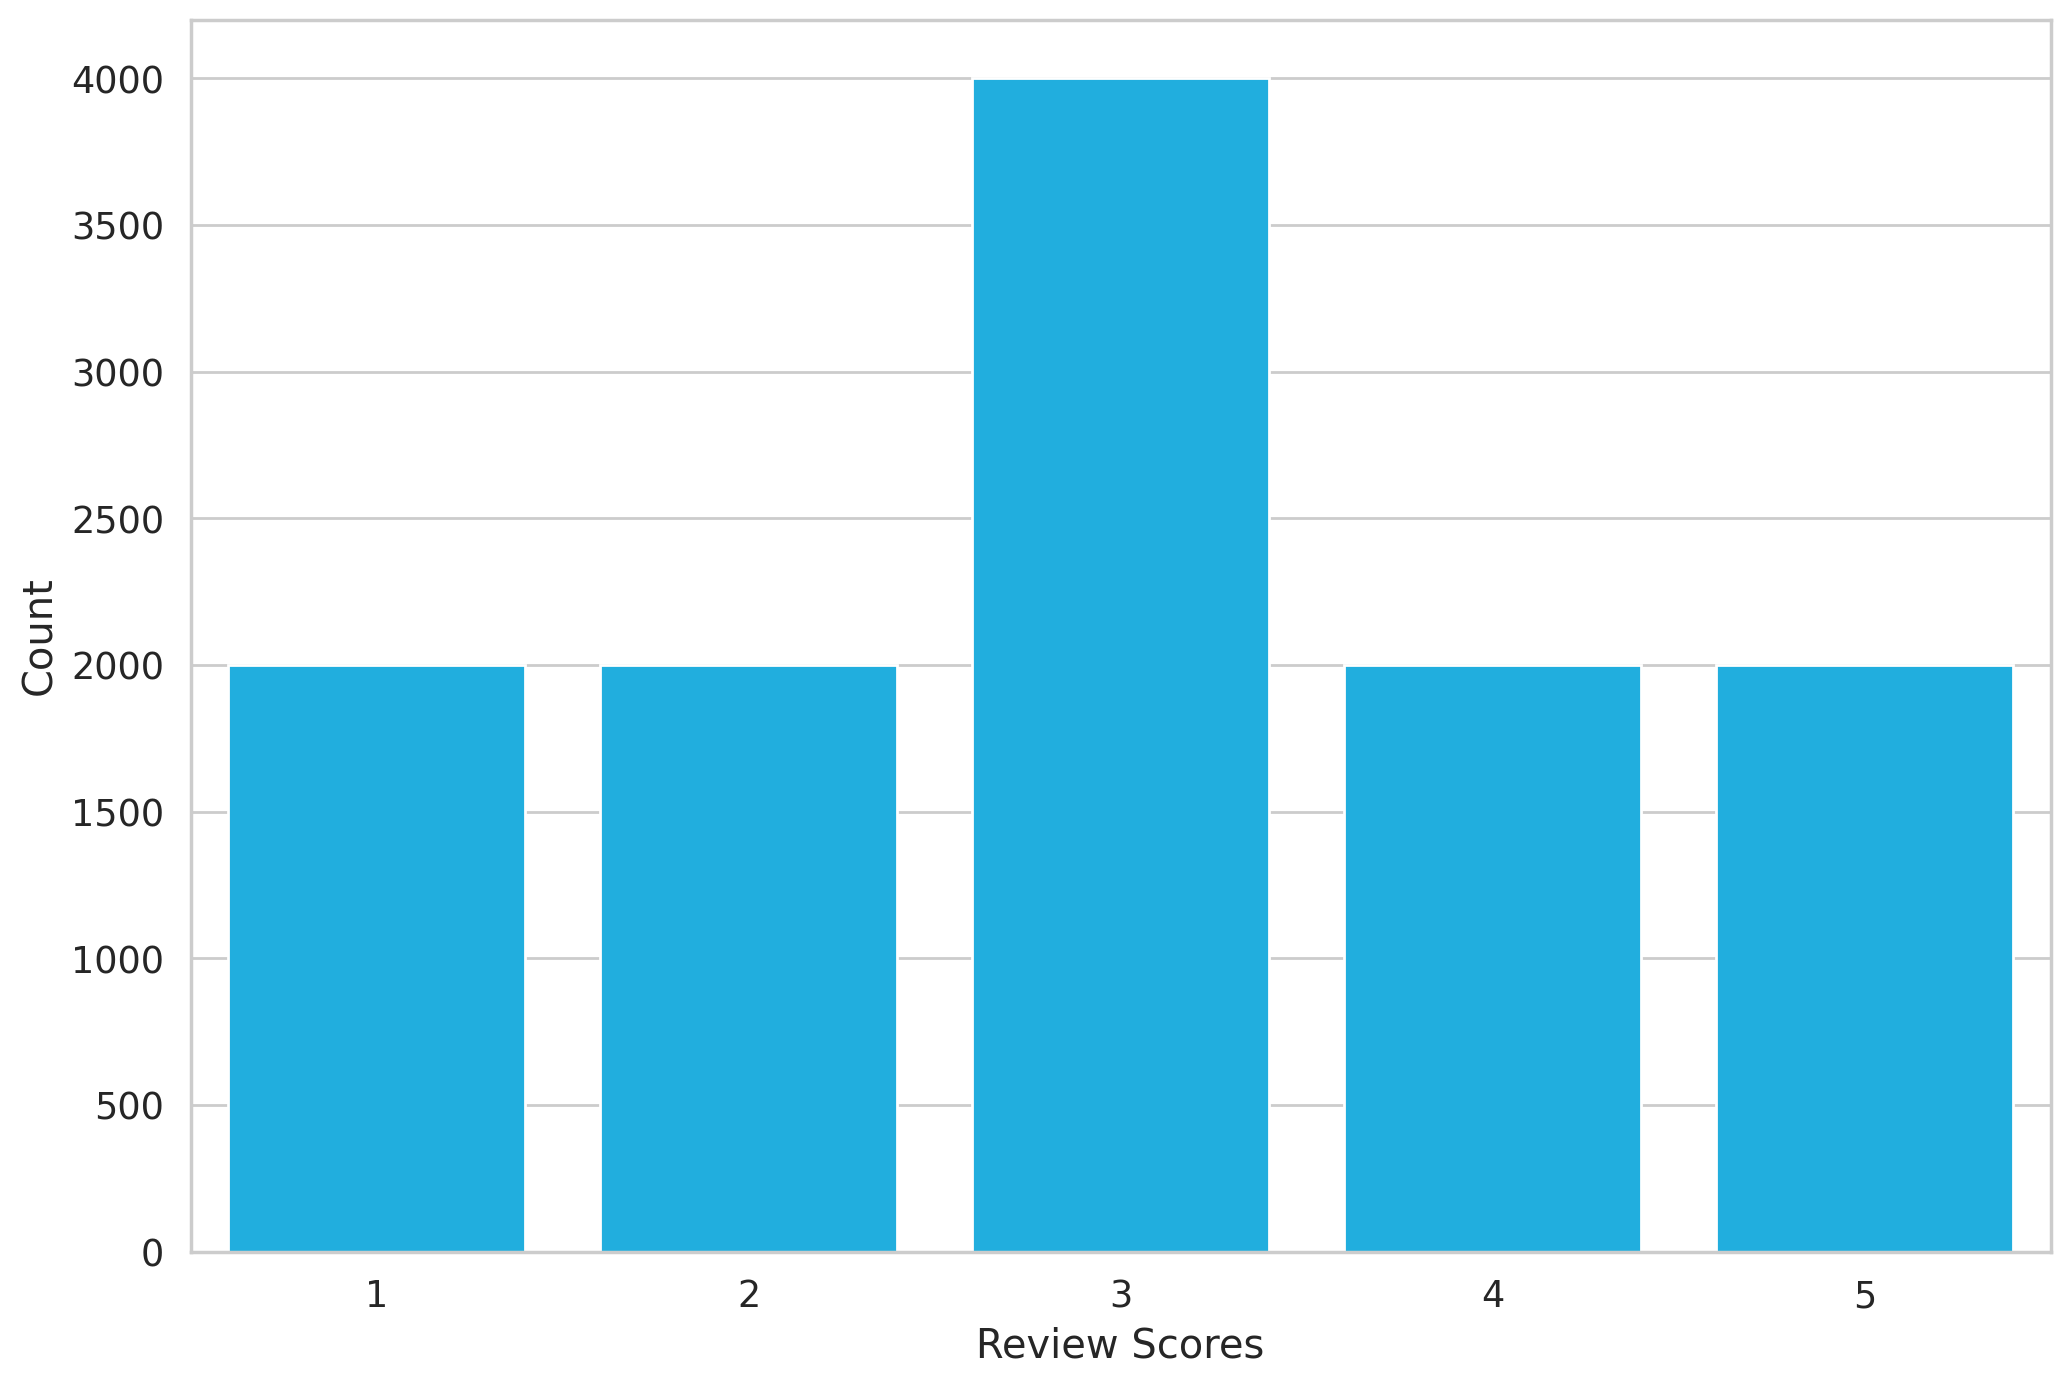

In [3]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

counts = df['rating'].value_counts().sort_index()

sns.barplot(x=counts.index, y=counts.values)
plt.xlabel("Review Scores")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

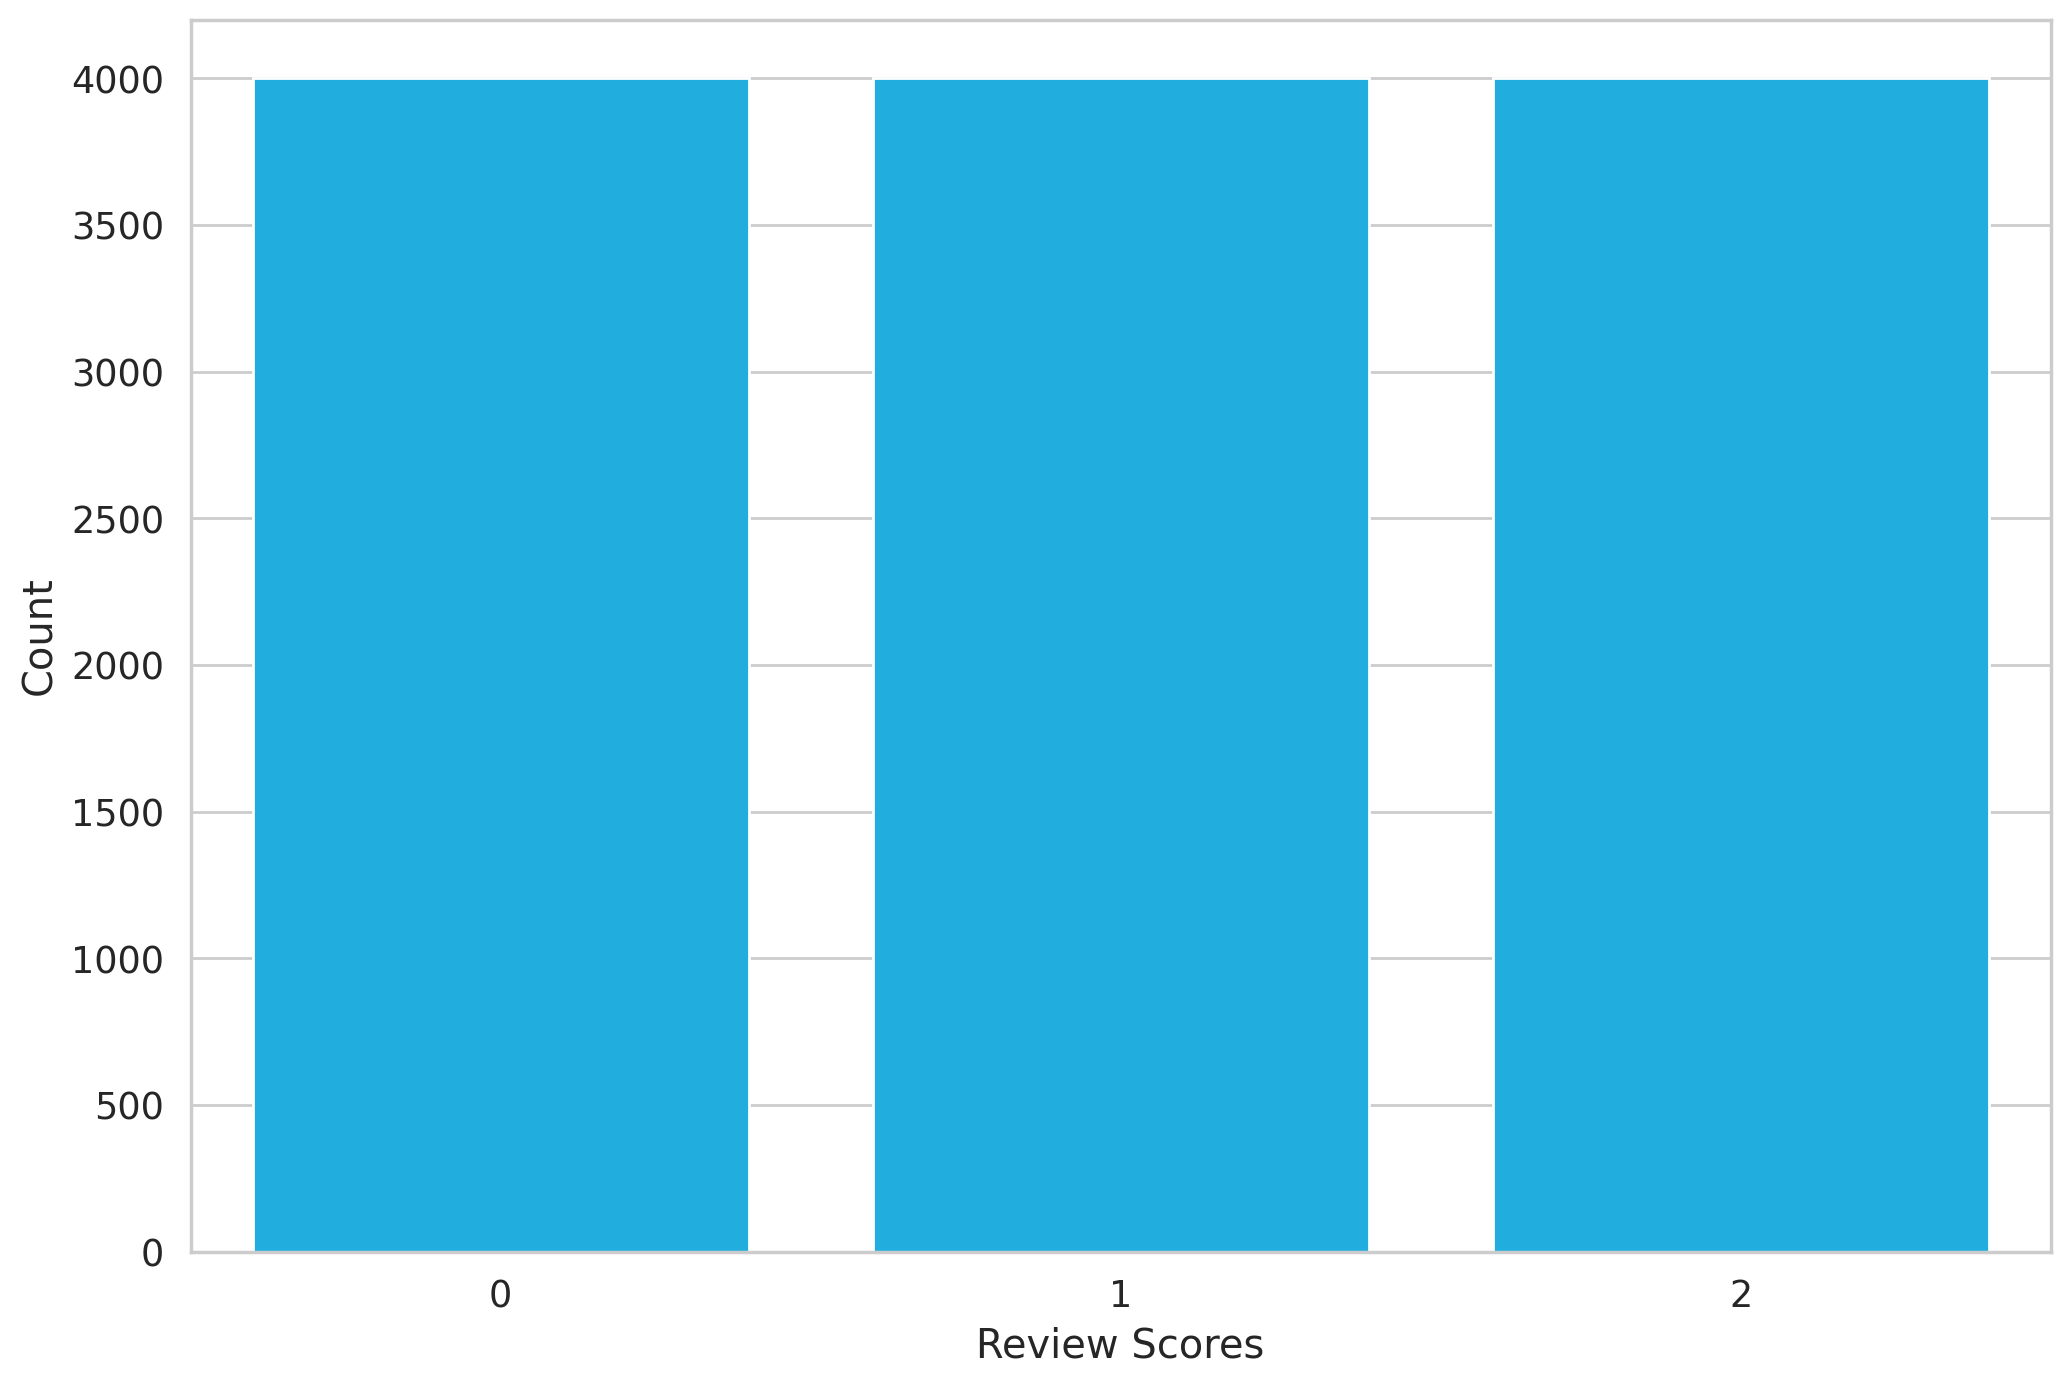

In [4]:
counts = df['label'].value_counts().sort_index()

sns.barplot(x=counts.index, y=counts.values)
plt.xlabel("Review Scores")
plt.ylabel("Count")

## Text Preprocessing

In [5]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import transformers
import torch

import copy
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torch import nn, optim
from torch.utils import data

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
sample_sentence = "When was I last outside? I've been at home for the last 4 days..."

In [10]:
tokens = tokenizer.tokenize(sample_sentence)

In [11]:
print(len(tokens))
print(tokens)

20
['when', 'was', 'i', 'last', 'outside', '?', 'i', "'", 've', 'been', 'at', 'home', 'for', 'the', 'last', '4', 'days', '.', '.', '.']


In [12]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [13]:
print(len(token_ids))
print(token_ids)

20
[2043, 2001, 1045, 2197, 2648, 1029, 1045, 1005, 2310, 2042, 2012, 2188, 2005, 1996, 2197, 1018, 2420, 1012, 1012, 1012]


## Special Tokens

These tokens let's BERT know that we are interested in sequence classification.

 - [SEP] separates the sentences.
 - [CLS] is a special token whose final embedding is essentially a summary for the whole input sequence and is commonly used for classificiation.
 - [PAD] is used to pad sequences to the same length for batching.
 - [UNK] is a word/token that isn't recognized by the tokenizer, unknown.

In [14]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [15]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [16]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [17]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [18]:
encoding = tokenizer.encode_plus(
    sample_sentence,
    max_length=32,
    add_special_tokens=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)

encoding.keys()

KeysView({'input_ids': tensor([[ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 1005, 2310, 2042, 2012,
         2188, 2005, 1996, 2197, 1018, 2420, 1012, 1012, 1012,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])})

In [19]:
encoding['input_ids'][0]

# Below you can see the '101' and '102' ids, which are the classification and separation
# special tokens.

tensor([ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 1005, 2310, 2042, 2012,
        2188, 2005, 1996, 2197, 1018, 2420, 1012, 1012, 1012,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [20]:
encoding['attention_mask'][0]

# In the print statement below, we can see how we don't make the model pay attention
# to the padding, and only on the original tokens.

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

### Choosing sequence length

Seems like most of my articles are around 0-100 tokens so I think 128 length is good.

In [21]:
token_lens = []

for article in df['text']:
  tokens = tokenizer.encode(article, max_length=512, truncation=True)
  token_lens.append(len(tokens))

/tmp/ipykernel_3106387/1057875912.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens);


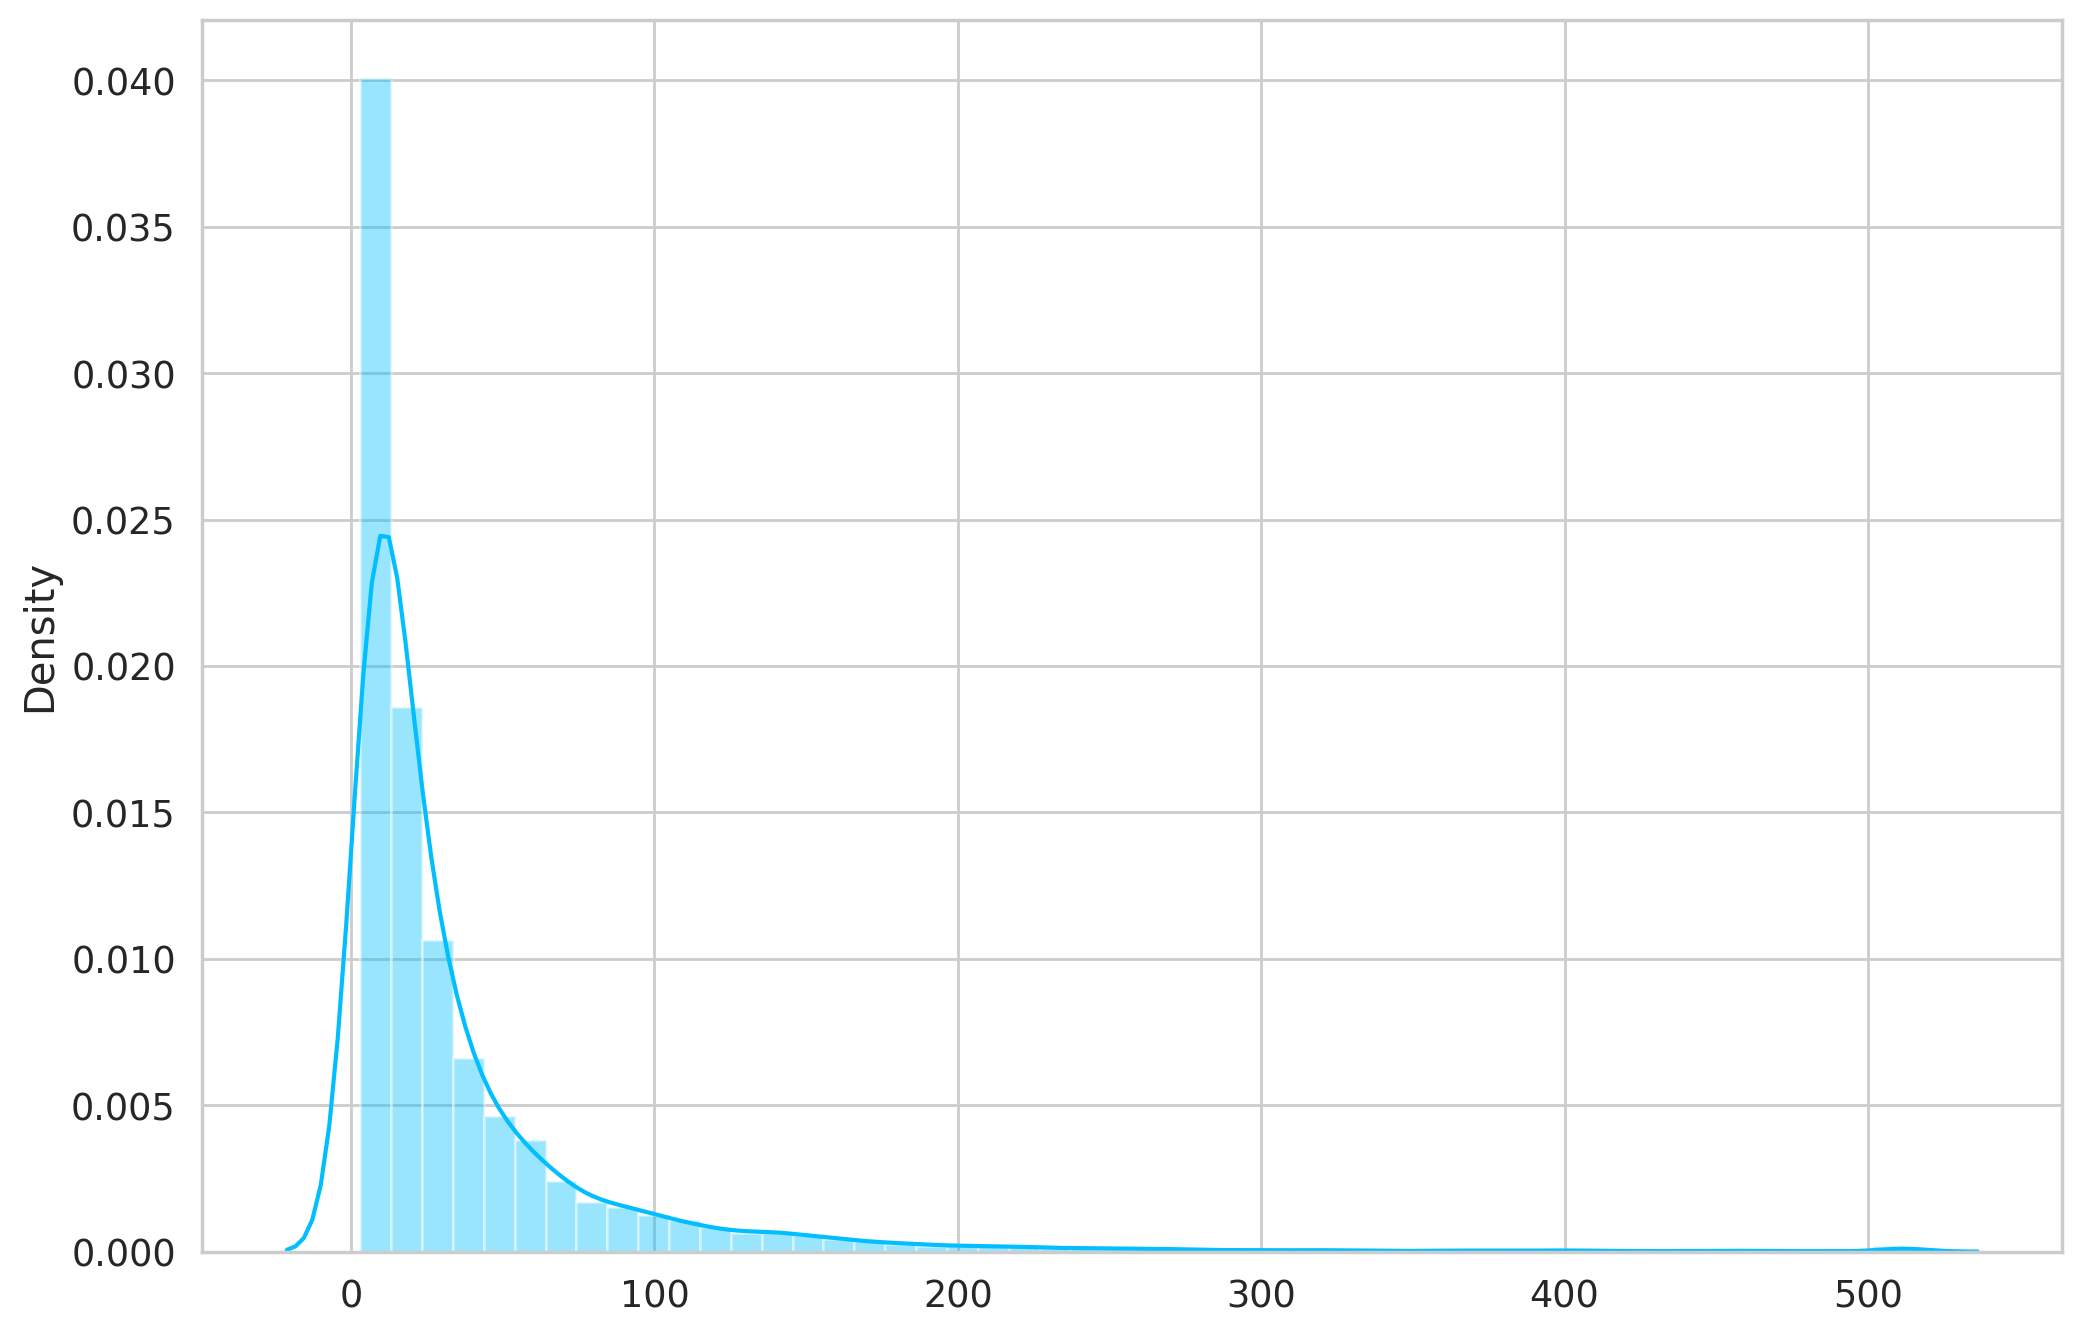

In [22]:
sns.distplot(token_lens);

### Creating PyTorch Dataset

In [23]:
class PTDataset(data.Dataset):

  def __init__(self, text, target, tokenizer, max_len):
    self.text = text
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])

    encoding = self.tokenizer.encode_plus(
      text,
      max_length=self.max_len,
      add_special_tokens=True,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_token_type_ids=False,
      return_tensors='pt'
    )

    return {
        'text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(self.target[item], dtype=torch.long)
    }

In [24]:
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 20

In [25]:
# Splitting data into train and test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [26]:
df_train.shape, df_val.shape, df_test.shape

((9600, 3), (1200, 3), (1200, 3))

In [27]:
def create_data_loader(df, tokenizer, max_len, batch_size, shuffle=False):
    ds = PTDataset(
        text=df['text'].to_numpy(),
        target=df['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return data.DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2,
        shuffle=shuffle
    )

In [28]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=True)
val_data_loader   = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=False)
test_data_loader  = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=False)

In [29]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [30]:
print(data['input_ids'])
data['input_ids'].shape

tensor([[  101,  2104, 14758,  ...,     0,     0,     0],
        [  101,  2004,  2204,  ...,     0,     0,     0],
        [  101,  4925,  2024,  ...,     0,     0,     0],
        ...,
        [  101,  9379,   102,  ...,     0,     0,     0],
        [  101,  2038,  2018,  ...,     0,     0,     0],
        [  101,  3835, 18105,  ...,     0,     0,     0]])


torch.Size([8, 128])

In [31]:
print(data['attention_mask'])
data['attention_mask'].shape

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


torch.Size([8, 128])

In [32]:
data['targets'].shape

torch.Size([8])

## Loading BERT Model

In [33]:
from transformers import BertModel
bert_model = BertModel.from_pretrained("bert-base-uncased")

/work/classtmp/NLP/venv/NLP/lib64/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/work/classtmp/NLP/venv/NLP/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [34]:
outputs = bert_model(
    input_ids=data["input_ids"],
    attention_mask=data["attention_mask"]
)

In [35]:
last_hidden_state = outputs.last_hidden_state
last_hidden_state.shape

"""
This gets us the last encoder's output values. The shape is (batch, seq_len, hidden_size),
each token is a 768-dim vector. Each token knows about all the other tokens in the review,
this last output is the deep semantic representations. BERT's final understanding of each
token. This was BERT's task #1, contextualized word embeddings with bi-directional language
modeling.
"""

"\nThis gets us the last encoder's output values. The shape is (batch, seq_len, hidden_size),\neach token is a 768-dim vector. Each token knows about all the other tokens in the review,\nthis last output is the deep semantic representations. BERT's final understanding of each\ntoken. This was BERT's task #1, contextualized word embeddings with bi-directional language\nmodeling.\n"

In [36]:
pooled_output = outputs.pooler_output
pooled_output.shape

"""
The pooled output takes the [CLS] token embedding from last_hidden_state[:, 0, :] and
passes it through a linear layer and tanh activation layer. It represents the whole
sequence, designed for classification tasks. This exists because BERT used [CLS] for
next-sentence prediction which was task #2 of BERT. It's basically sentence/review-level
meaning. This shape is (batch, hidden_size).
"""

"\nThe pooled output takes the [CLS] token embedding from last_hidden_state[:, 0, :] and\npasses it through a linear layer and tanh activation layer. It represents the whole\nsequence, designed for classification tasks. This exists because BERT used [CLS] for\nnext-sentence prediction which was task #2 of BERT. It's basically sentence/review-level\nmeaning. This shape is (batch, hidden_size).\n"

## Building the Sentiment Classifier

In [37]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained("bert-base-uncased")
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
    )
    pooled_output = outputs.pooler_output
    output = self.drop(pooled_output)
    output = self.out(output)
    return output

In [38]:
model = SentimentClassifier(len(df['label'].unique()))
model = model.to(device)

In [39]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([8, 128])
torch.Size([8, 128])


In [40]:
model(input_ids, attention_mask)

tensor([[-0.0526, -0.4568,  0.7782],
        [-0.2760,  0.0057,  0.2178],
        [-0.3540, -0.5858,  1.0639],
        [ 0.0583, -0.3423,  0.6528],
        [-0.0296, -0.3687,  0.7761],
        [-0.3517,  0.0729,  0.2851],
        [ 0.3956,  0.1957,  0.5429],
        [-0.0212, -0.0551,  0.6078]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

### Training

In [41]:
from transformers import get_linear_schedule_with_warmup

optimizer = optim.Adam(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [42]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

    _, pred = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(pred == targets)
    losses.append(loss.item())

    loss.backward()

    # Gradient clipping to avoid gradient explosion
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [43]:
from sklearn.metrics import f1_score

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  all_preds = []
  all_targets = []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
      )

      _, pred = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      all_preds.extend(pred.cpu().numpy())
      all_targets.extend(targets.cpu().numpy())
      correct_predictions += torch.sum(pred == targets)
      macro_f1 = f1_score(all_targets, all_preds, average="macro")
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses), macro_f1

In [44]:
if torch.cuda.is_available():
    print("CUDA is available! Using GPU.")
    print(f"Current CUDA device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available! Using GPU.
Current CUDA device: NVIDIA A100 80GB PCIe


In [45]:
%%time

from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

best_f1 = -1
patience = 3
patience_counter = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
  )

  print(f'Train loss: {train_loss}, accuracy: {train_acc}')

  val_acc, val_loss, val_f1 = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
  )

  print(f'Val loss: {val_loss}, accuracy: {val_acc}, macroF1: {val_f1}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  # if val_acc > best_accuracy:
  #   torch.save(model.state_dict(), 'best_model_state.bin')
  #   best_accuracy = val_acc
  if val_f1 > best_f1:
    torch.save(model.state_dict(), "best_model_state.bin")
    best_f1 = val_f1
    patience_counter = 0
  else:
    patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stoppage: no improvement in macro F1 for {patience} epochs.")
        break

Epoch 1/20
----------
Train loss: 0.7236801607285936, accuracy: 0.6688541666666667
Val loss: 0.6409153716762861, accuracy: 0.7250000000000001, macroF1: 0.7259375464805072

Epoch 2/20
----------
Train loss: 0.5465937396790832, accuracy: 0.7753125000000001
Val loss: 0.6669864981869856, accuracy: 0.7433333333333334, macroF1: 0.7365419819288112

Epoch 3/20
----------
Train loss: 0.39833738321593654, accuracy: 0.8557291666666668
Val loss: 0.8309809928387404, accuracy: 0.7041666666666667, macroF1: 0.6992761990180628

Epoch 4/20
----------
Train loss: 0.30455784722871615, accuracy: 0.9076041666666668
Val loss: 1.2989305310448012, accuracy: 0.7008333333333334, macroF1: 0.7031935087600377

Epoch 5/20
----------
Train loss: 0.23797922122544454, accuracy: 0.9341666666666667
Val loss: 1.2799452370746682, accuracy: 0.7200000000000001, macroF1: 0.7173882954179712

Early stoppage: no improvement in macro F1 for 3 epochs.
CPU times: user 4min 43s, sys: 2.23 s, total: 4min 45s
Wall time: 4min 48s


## Evaluation

In [46]:
class_names = ['negative', 'neutral', 'positive']
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [47]:
def get_reviews(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d['text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return review_texts, predictions, prediction_probs, real_values    

In [48]:
test_acc, test_loss, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

In [49]:
test_acc

tensor(0.7092, device='cuda:0', dtype=torch.float64)

### Accuracy

Accuracy was about 71%, not bad at all especially since reviews can be inherently so noisy. For example, "Food was ok, drinks were really good, but prices are fair.", even for human it can be difficult to say "Yes this definitely this sentiment class".

In [50]:
y_review_texts, y_pred, y_pred_probs, y_test = get_reviews(model, test_data_loader)

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.72      0.83      0.77       420
     neutral       0.63      0.51      0.56       406
    positive       0.76      0.79      0.78       374

    accuracy                           0.71      1200
   macro avg       0.70      0.71      0.70      1200
weighted avg       0.70      0.71      0.70      1200



### Precision, Recall, F1

We can see that model does a better job with 'negative' & 'positive' class compared to 'neutral'. Given my example earlier, it makes sense to rule it either 'positive' or 'neutral' so it can even be hard for humans.

In [52]:
def visualize_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")

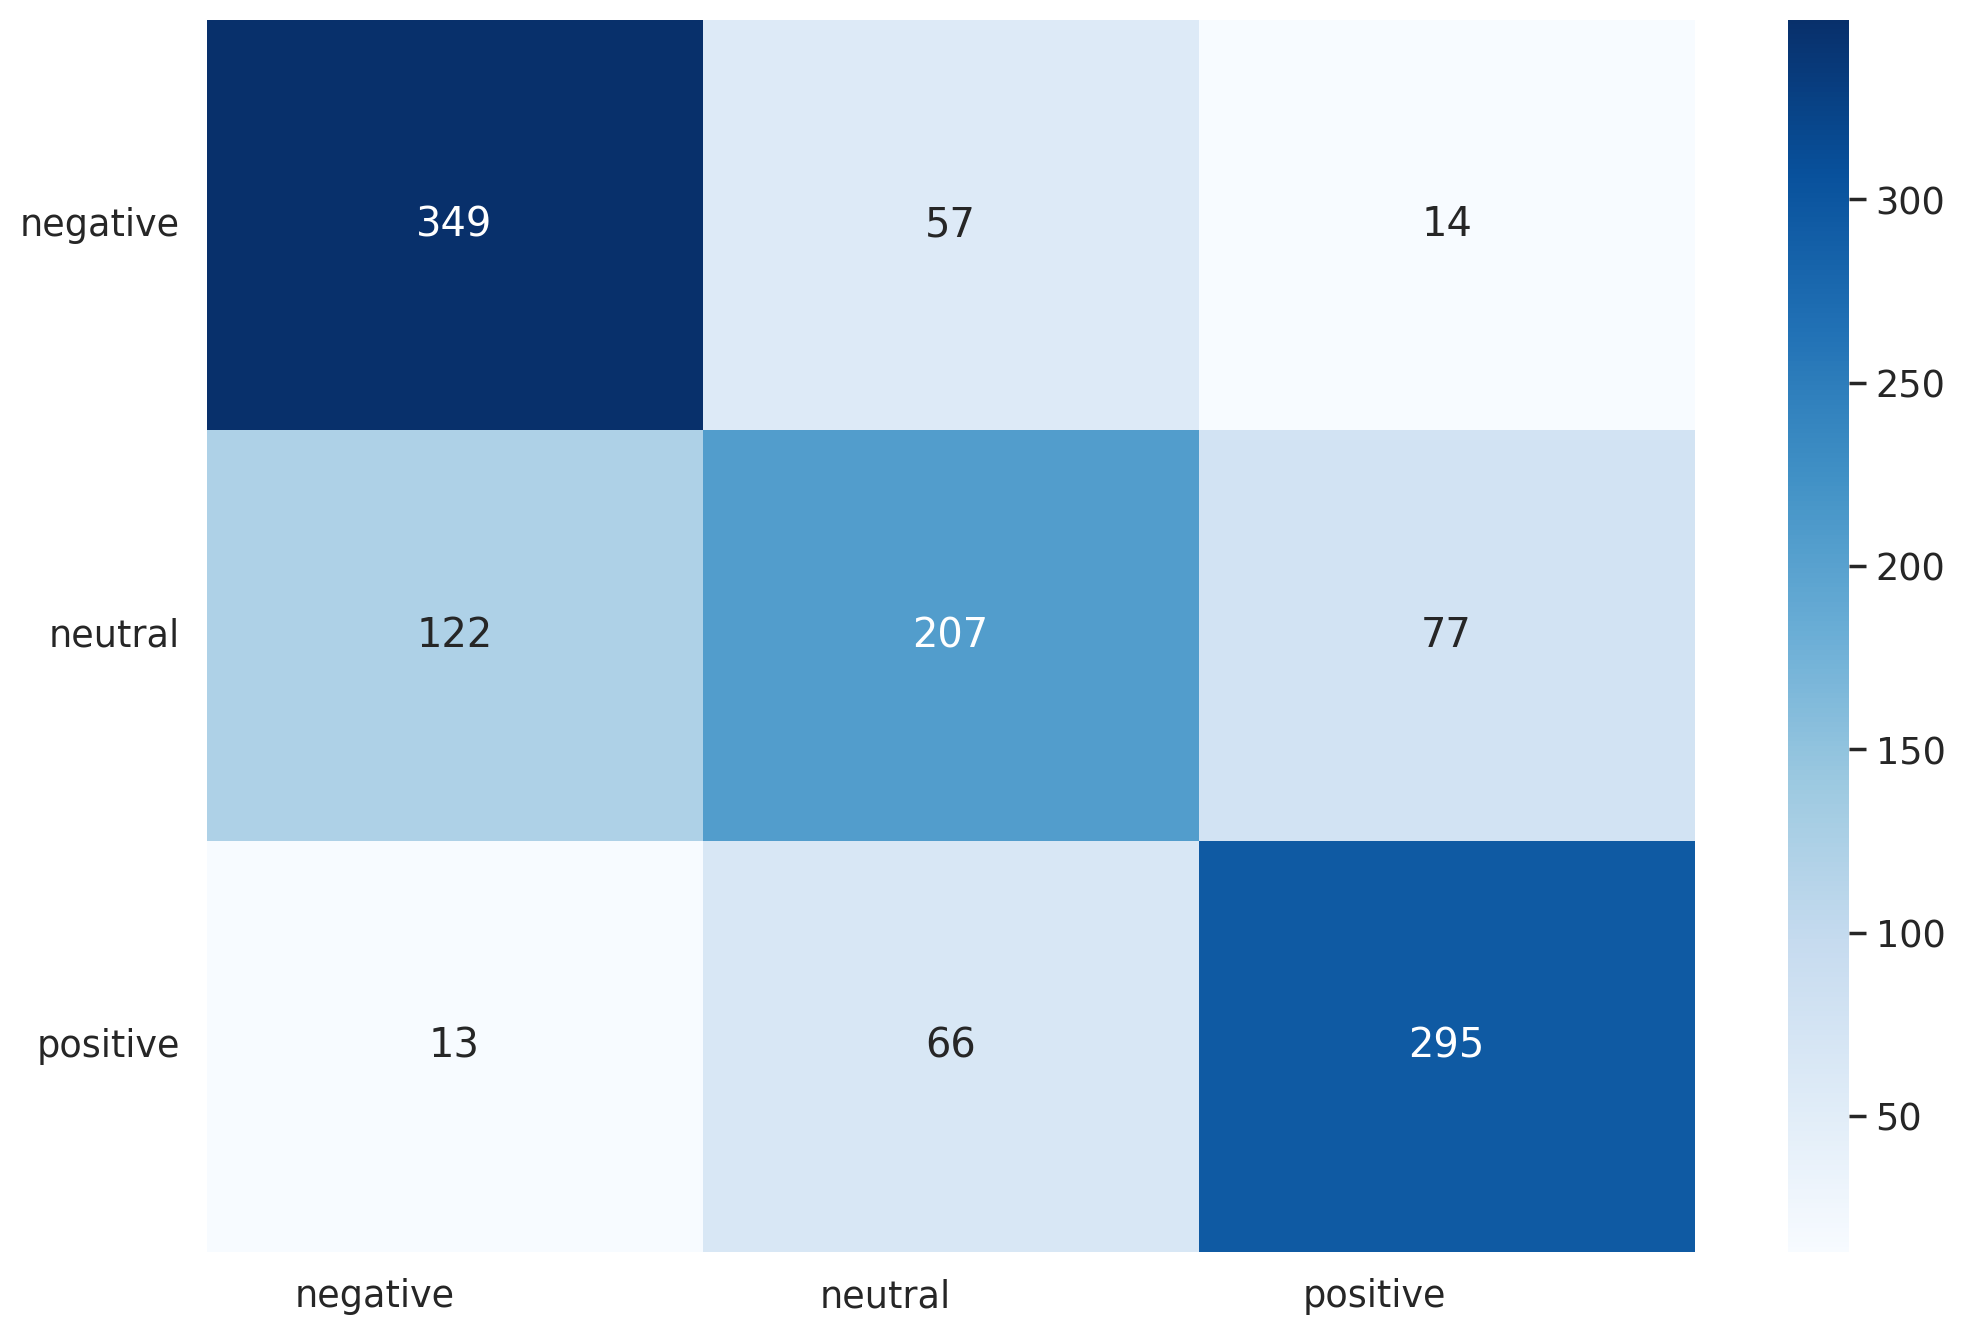

In [57]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
visualize_confusion_matrix(df_cm)

In [66]:
from textwrap import wrap

idx = 69
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]

pred_df = pd.DataFrame(
    {
        'class_names': class_names,
        'values': y_pred_probs[idx]
    }
)

print("\n".join(wrap(review_text)))
print()
print(f'True Sentiment: {class_names[true_sentiment]}')

Great People and Cold Beer. Don't get any better.

True Sentiment: positive


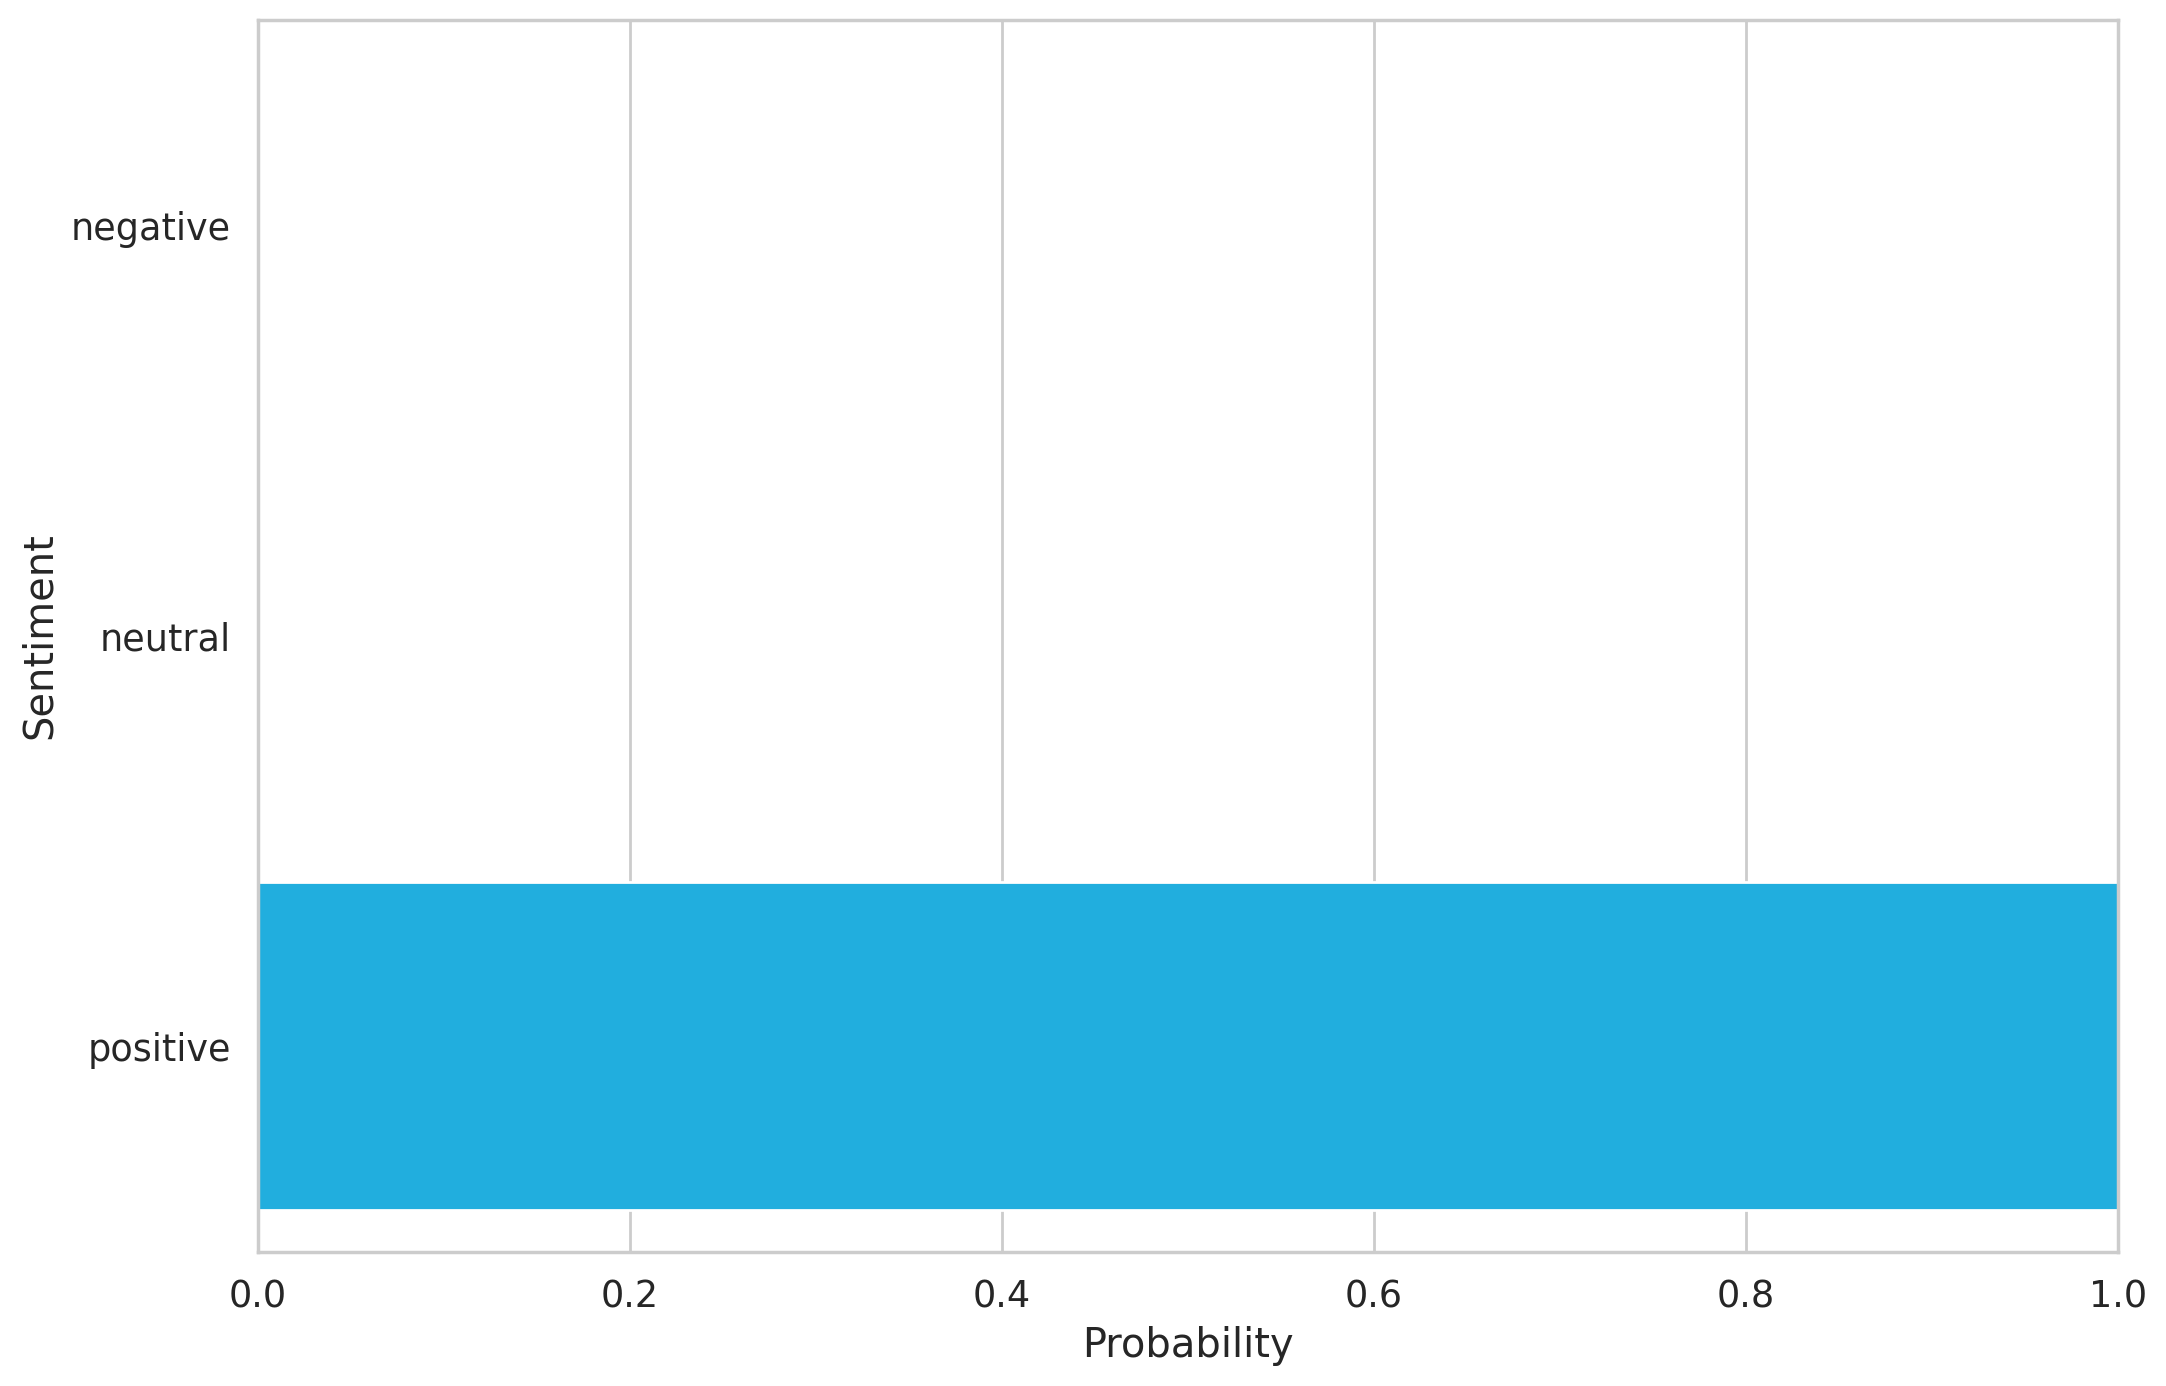

In [67]:
sns.barplot(x="values", y="class_names", data=pred_df, orient="h")
plt.ylabel('Sentiment')
plt.xlabel('Probability')
plt.xlim([0,1]);

## Predict Sentiment on Raw Text of our own

In [69]:
review_text = "I really like their chicken. It's so crispy and not dry!"

In [71]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)

In [72]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

In [73]:
output = model(input_ids, attention_mask)
_, pred = torch.max(output, dim=1)

In [ ]:
print(f'Review Text: {review_text}')
print(f'Sentiment